In [140]:
import os
import torch
from torch.utils.data import Dataset
from taskdataset import TaskDataset
import matplotlib.pyplot as plt
import torchvision.models as models
from torch import nn
import torchvision.transforms as T
import requests
import json


os.chdir("/net/tscratch/people/plglukaszst/projects/ensemble-ai2024/modelstealing")

In [141]:
ds_orig = torch.load("/net/tscratch/people/plglukaszst/projects/ensemble-ai2024/modelstealing/data/ModelStealingPub.pt")
sample_orig = ds_orig[0]

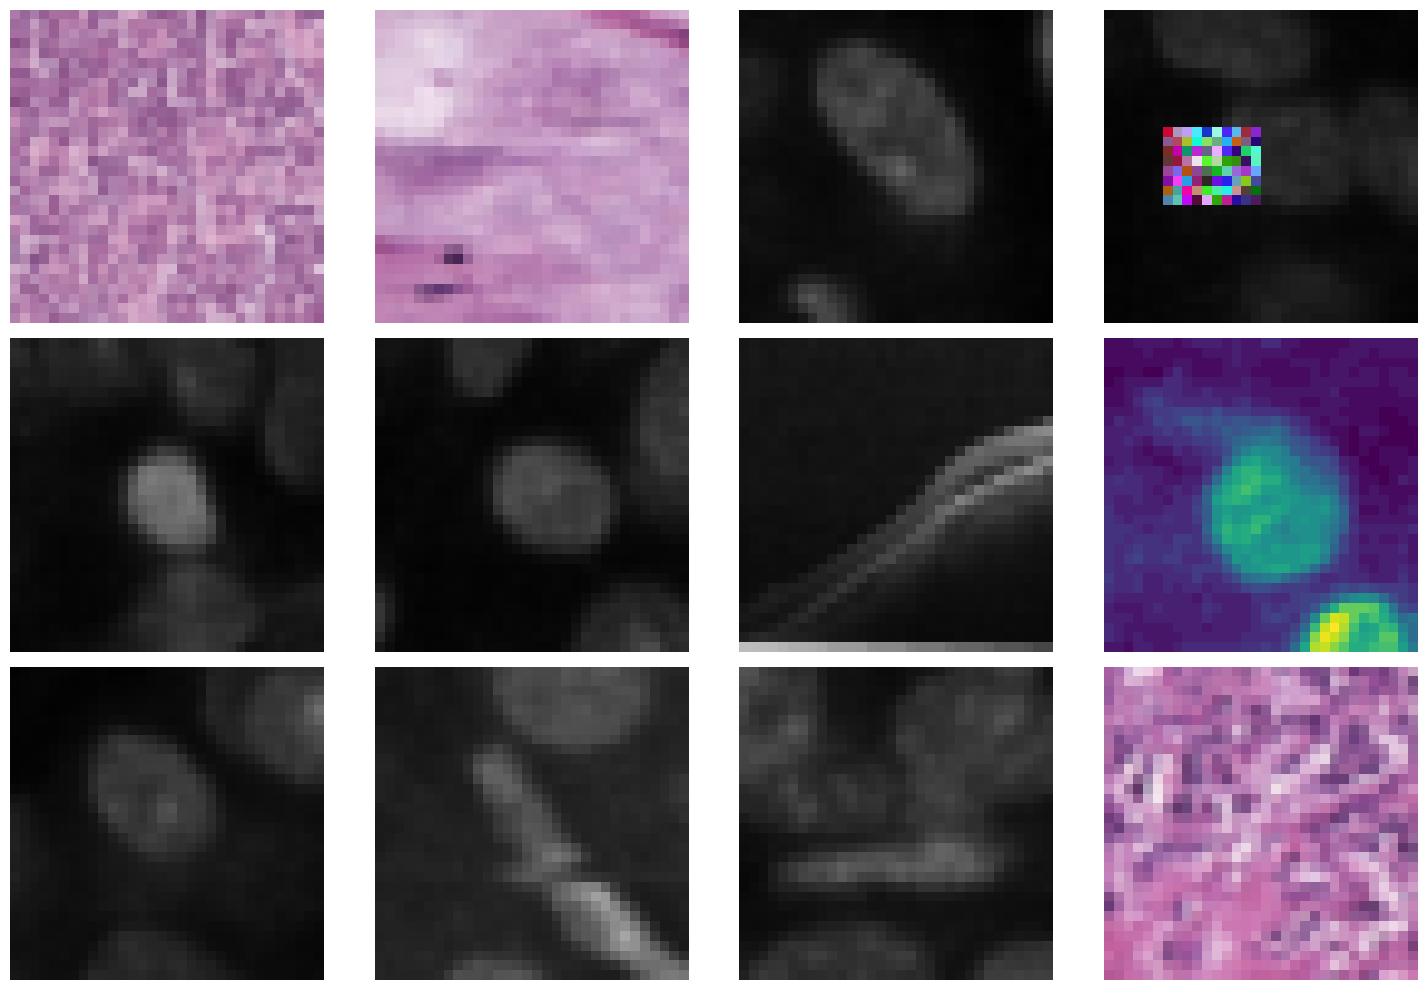

In [142]:
ds_orig = torch.load("/net/tscratch/people/plglukaszst/projects/ensemble-ai2024/modelstealing/data/ModelStealingPub.pt")

def plot_images(images):
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))

    for i, ax in enumerate(axs.flatten()):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()
plot_images([ds_orig[idx][1] for idx in range(12)])

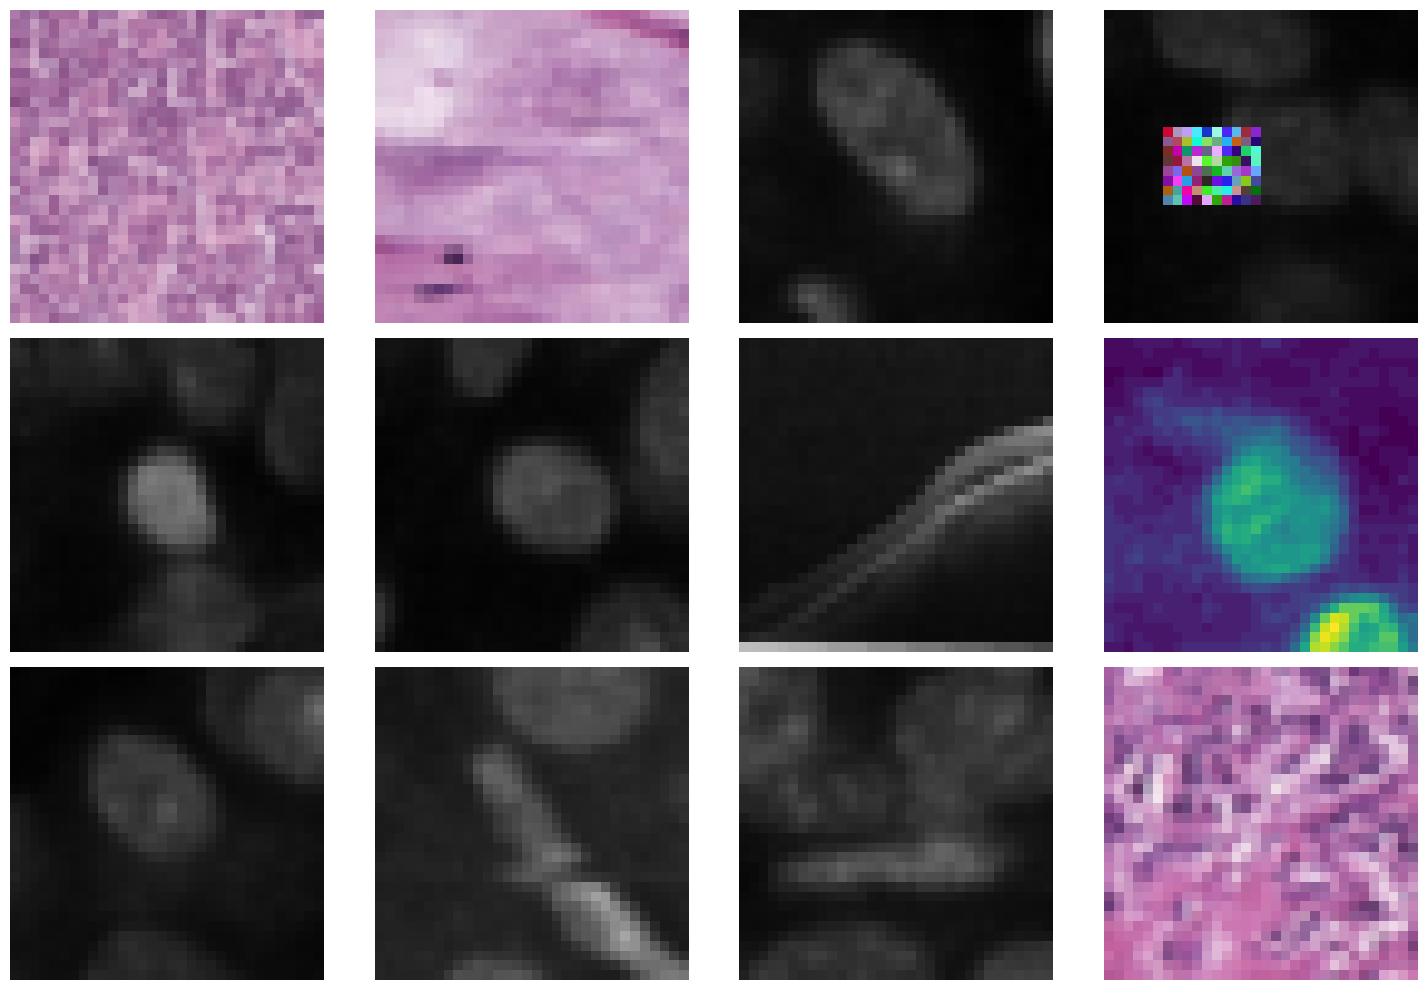

In [143]:
plot_images([ds_orig[idx][1] for idx in range(12)])

In [104]:
victim_model = models.__dict__["resnet50"]()
checkpoint = torch.load(
    "/net/tscratch/people/plglukaszst/projects/ensemble-ai2024/modelstealing/models/checkpoint_0099.pth.tar",
    map_location="cpu",
)
state_dict = checkpoint["state_dict"]
for k in list(state_dict.keys()):
    if k.startswith("module.encoder") and not k.startswith("module.encoder.fc"):
        state_dict[k[len("module.encoder.") :]] = state_dict[k]
    del state_dict[k]
victim_model.load_state_dict(state_dict, strict=False)
victim_model.fc = torch.nn.Identity()
victim_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [123]:
class OurModel(nn.Module):
    def __init__(self):
        super().__init__()

        victim_model = models.__dict__["resnet50"]()
        checkpoint = torch.load(
            "/net/tscratch/people/plglukaszst/projects/ensemble-ai2024/modelstealing/models/checkpoint_0099.pth.tar",
            map_location="cpu",
        )
        state_dict = checkpoint["state_dict"]
        for k in list(state_dict.keys()):
            if k.startswith("module.encoder") and not k.startswith("module.encoder.fc"):
                state_dict[k[len("module.encoder.") :]] = state_dict[k]
            del state_dict[k]
        victim_model.load_state_dict(state_dict, strict=False)

        self.layer = nn.Sequential(victim_model.conv1, victim_model.bn1, victim_model.relu, victim_model.maxpool)
        self.layer1 = victim_model.layer1
        self.layer2 = victim_model.layer2
        self.avg_pool = victim_model.avgpool
    def forward(self, x):
        x = self.layer(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pool(x)
        return x.squeeze()

In [125]:
# victim_model = victim_model.cpu()
model = OurModel()
model = model.to("cuda")

In [107]:
class XDDataset(Dataset):
    def __init__(self, ds_orig: Dataset):
        self.ds_orig = ds_orig

    def len(self):
        return len(self.ds_orig)

    def __getitem__(self, idx):
        return T.ToTensor()(self.ds_orig[idx][1])

In [108]:
ds = XDDataset(ds_orig=ds_orig)

In [109]:
with torch.no_grad():
    y = model(ds[0].unsqueeze(0).to("cuda"))

In [110]:
y.shape

torch.Size([512])

In [126]:
def model_stealing(path_to_png_file: str):
    SERVER_URL = "http://34.71.138.79:9090"
    ENDPOINT = "/modelstealing"
    URL = SERVER_URL + ENDPOINT

    TEAM_TOKEN = "8J40ASDQOjfeeSKL"

    with open(path_to_png_file, "rb") as img_file:
        response = requests.get(
            URL, files={"file": img_file}, headers={"token": TEAM_TOKEN}
        )

        if response.status_code == 200:
            return response
        else:
            raise Exception(f"Request failed. Status code: {response.status_code}, content: {response.content}")

In [144]:
x = model_stealing("/net/tscratch/people/plglukaszst/projects/ensemble-ai2024/modelstealing/xd.png")

In [149]:
import json

In [150]:
json.loads(x.content)

{'representation': [7.401433355092024e-10,
  2.9894969832966467e-10,
  2.4128029346466064,
  2.9264943599700928,
  7.148621139485556e-10,
  1.0252782650654879e-10,
  4.784115881228956e-10,
  1.322983741760254,
  4.908630168998229e-10,
  1.0621871948242188,
  3.6344618797302246,
  -6.5047744968183e-10,
  5.764840602874756,
  -3.185429975349763e-10,
  6.830075394148594e-10,
  1.8371137380599976,
  0.9490261673927307,
  3.980280272042336e-10,
  9.438472919898189e-11,
  0.05760164558887482,
  -6.267127927728211e-10,
  3.9445719718933105,
  3.271460602416454e-10,
  6.112370054545124e-10,
  -7.188107054023618e-11,
  1.0271683931350708,
  -6.787543305186716e-10,
  4.3770703728185367e-10,
  0.5825575590133667,
  4.441150188446045,
  5.684510084869032e-10,
  4.075135229264504e-10,
  4.3425962825693887e-10,
  0.36994442343711853,
  2.687593460083008,
  0.5951381921768188,
  -1.856014508749837e-10,
  -1.1630032353826536e-10,
  -1.8651079292109074e-10,
  0.5944050550460815,
  1.1431918744975178e-0

In [128]:
model = model.cpu()

In [131]:
# store model
def save_model(model: nn.Module, path_to_onnx_file: str):
    os.makedirs("models", exist_ok=True)
    torch.onnx.export(
        model,
        torch.randn(1, 3, 32, 32),
        path_to_onnx_file,
        export_params=True,
        input_names=["x"],
    )


In [132]:
save_model(model, "model.onnx")

In [133]:
# submission
def model_stealing_submit(path_to_onnx_file: str):
    SERVER_URL = "http://34.71.138.79:9090"
    TEAM_TOKEN = "8J40ASDQOjfeeSKL"
    endpoint = "/modelstealing/submit"
    url = SERVER_URL + endpoint
    with open(path_to_onnx_file, "rb") as f:
        response = requests.post(url, files={"file": f}, headers={"token": TEAM_TOKEN})
        if response.status_code == 200:
            print("Request ok")
            print(response.json())
        else:
            raise Exception(
                f"Model stealing submit failed. Code: {response.status_code}, content: {response.json()}"
            )

# model_stealing_submit("models/example_submission.onnx")

In [134]:
x = model_stealing_submit("model.onnx")

In [135]:
x

<Response [500]>